In [17]:
import networkx as nx
from z3 import Int
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
delays = {
    "load": 3,
    "add": 1,
    "store": 1,
}

# Operations

{(0, 4): Text(0.3604343229748254, 0.3000869044327655, '3'),
 (1, 3): Text(-0.3082920872563103, -0.5309204053695399, '3'),
 (2, 3): Text(-0.6424529805812624, -0.3768286102808132, '3'),
 (3, 4): Text(-0.09340476210966638, 0.12909320003613367, '1'),
 (4, 5): Text(0.496905982753081, 0.7367553112537211, '1')}

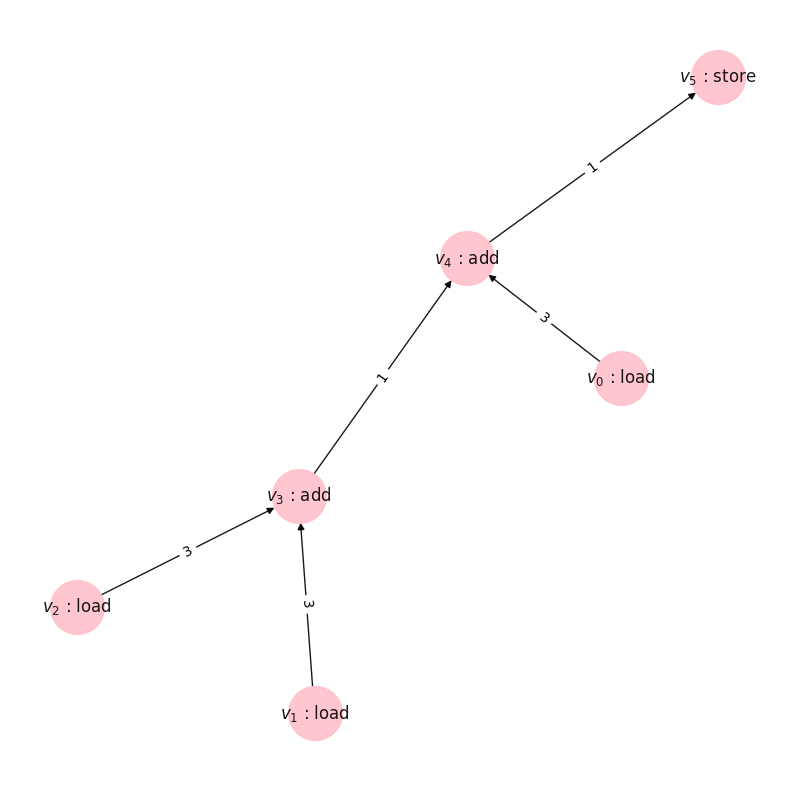

In [49]:
G = nx.DiGraph()
V = [0, 1, 2, 3, 4, 5]
G.add_nodes_from([0, 1, 2], type="load")
G.add_nodes_from([3, 4], type="add")
G.add_nodes_from([5], type="store")
G.add_edges_from([
    (0, 4),
    (1, 3),
    (2, 3),
    (3, 4),
    (4, 5),
])

for u, v in G.edges():
    G[u][v]["delay"] = delays[G.nodes[u]["type"]]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, ax=ax, edge_color='black', width=1, linewidths=1,
    node_size=1500, node_color='pink', alpha=0.9,
    labels={node: f"$v_{node}$ : {G.nodes[node]['type']}" for node in G.nodes()}
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'delay'))

# Schedule variables

In [55]:
s = [Int(f's_{node}') for node in G.nodes()]
s

[s_0, s_1, s_2, s_3, s_4, s_5]

# Timing constraints

In [56]:
dependence_constraints = [
    s[0] - s[1] <= 0,
    s[1] - s[3] <= 0,
    s[2] - s[3] <= 0,
    s[3] - s[4] <= 0,
    s[4] - s[5] <= 0,
]
dependence_constraints

[s_0 - s_1 <= 0,
 s_1 - s_3 <= 0,
 s_2 - s_3 <= 0,
 s_3 - s_4 <= 0,
 s_4 - s_5 <= 0]

Suppose a target clock period $T_{clk}$ of 5ns.

To honor the target clock period $T_{clk}$, the "maximum critical combinational path delay" $D(ccp(v_i, v_j)) := \max_{v_i \leadsto v_j} \sum_{i \leadsto k \leadsto j} D(v_k) $ (this is a max over paths) between pairs of operations must be partitioned into $\lceil D(ccp(v_i, v_j)) / T_{clk} \rceil$ clock cycles if it, $D(ccp(v_i, v_j))$, exceeds $T_{clk}$. This can encoded as the constraint

$$
    s_i + \left( \left\lceil \frac{D(ccp(v_i, v_j))}{T_{clk}}   \right\rceil -1 \right) \leq s_j
$$

i.e. forgetting about the ceiling, there needs to be an artificial (forced) delay of $n - 1$ periods of length $T_{clk}$ between $v_i$ and $v_j$, where $ n := D(ccp(v_i, v_j)) / T_{clk} $ so that the critical path is a whole number multiple of $T_{clk}$ (thereby enabling achieving $T_{clk}$). This is rewritten as
$$
    s_i - s_j \leq - \left( \left\lceil \frac{D(ccp(v_i, v_j))}{T_{clk}}   \right\rceil -1 \right)
$$

In the above graph $D(ccp(v_2, v_5)) = 6\text{ns}$, exceeding 5ns, we get the constraint

$$
    s_2 - s_5 \leq - \left( \left\lceil \frac{6}{5} \right\rceil -1 \right) = - (2 - 1) = -1
$$

ensuring that $v_5$ is scheduled at least one cycle after $v_2$. Similarly for $v_1$ and $v_5$. Thus

In [54]:
cycle_time_constraints = [
    s[2] - s[5] <= -1,
    s[1] - s[5] <= -1,
]
cycle_time_constraints

[s_2 - s_5 <= -1, s_1 - s_5 <= -1]

# Resource constraints

While SDC is able to model timing constraints exactly, it must heuristically transform resource constraints into the integer difference form by imposing a particular **heuristic linear ordering** on the resource-constrained operations. This process separates resource constrained operations appropriately into different cycles to ensure that sufficient resources are available to execute operations scheduled within the same cycle. **The linear ordering consists of a set of precedence relationships between pairs of resource-constrained operations $v_i$ and $v_j$ represented in the form of**

$$
    s_i + L_i \leq s_j
$$

where $L_i$ denotes the latency (delay) of the operation performed at $v_i$. Again this is a kind of buffer in between the operations and again this is usually rewritten as

$$
    s_i - s_j \leq L_i
$$

Note that the induced linear ordering here is not the same ordering induced by data flow; for example, suppose there were only two read ports on a memory and only two of $v_0, v_1, v_2$ can execute at the same time. One heuristic ordering of the contentious operations (three operations contending for two read ports) is

\begin{align}
    s_0 - s_1 \leq -1 \\
    s_2 - s_1 \leq -1 \\
\end{align}

i.e., $s_0, s2$ read first and then $s_1$ reads. Alternatively,

\begin{align}
    s_1 - s_0 \leq -1 \\
    s_2 - s_0 \leq -1 \\
\end{align}

i.e., $s_1, s2$ read first and then $s_0$ reads. Hence, "heuristic" linear ordering, since there are many to choose from. But different orderings, while legal, can lead to differing end-to-end latencies.

# ILP formulation

Declare $x_{it}$, a binary variable, which denotes whether operation $i$ starts at clock cycle $t$. Then the start time can be expressed as

$$
    s_i = \sum_{t=0}^{L-1} t \cdot x_{it}
$$

where $L$ is maximum possible delay. Essentially this is a one-hot encoding of the start time. In the ILP formulation, resource constraints can be encoded exactly (no heuristics):

$$
    \sum_{\left( \text{operation $i$ using resource $r$} \right)} \sum_{t' = t - L_i}^{t} x_{it} \leq a_r
$$

which expresses that for resource type $r$, the quantity of operations $i$ using resource type $r$ in any clock cycle $t$, and in the previous $L_i$ clock cycles, cannot exceed the availability $a_r$ of resource type $r$. **Recall that $x_{it}$ are binary** so the inner sum is effectively counts the number of active operations. Finally ILP requires that each operation start at a unique time:

$$
\sum_t x_{it} = 1
$$

# SAT Formulation

A SAT formulation is pretty close to the ILP formulation: boolean $x_{it}$ denotes whether operation $i$ starts at clock cycle $t$ and boolean $u_{it}$ (a *process variable*) denotes whether operation $i$ is active/running during clock cycle $t$. Dependence can be expressed as conjunctive normal form formulae on these variables; to provide a correct combination of start and process variables for each activity we need *consistency clauses*:

$$
    \left( x_{it} \implies u_{il} \right) \iff \left( \neg x_{it} \vee u_{il} \right) , \quad l \in \{t,\dots,t+L_i-1\}
$$

i.e. if operation $i$ starts at clock cycle $t$ it has to be active during each of the next $l$ clock cycles, until $t + L_i$; to guarantee the satisfaction of operation precedence constraints we need *precedence clauses*:

\begin{align}
    x_{it} \implies x_{jl}, \; l \leq s_i - L_j  &\quad \forall j \text{ s.t. } (j,i) \in E \\
    & \iff \\
    \neg x_{it} \bigvee x_{jl}, \quad l \leq s_i - L_j  &\quad \forall j \text{ s.t. } (j,i) \in E
\end{align}

i.e., if operation $i$ starts at clock cycle $t$, all of its predecessors start early enough that they can finish before. Resource constraints are expressed by introduction of boolean binding variables $B_{ik}$, denoting whether operation $i$ is bound to resource $k$. For example, operations $v_0, v_1, v_2$ can be bound to one of two read ports $k=0,1$ and therefore we declare $\{B_{00}, B_{01}, B_{10}, B_{11}, B_{20}, B_{21}\}$. We constrain the $B_{ij}$

$$
    \sum_k B_{ik} = 1
$$

to enforce that each operation is bound to exactly one resource. Based on the binding variables, a sharing variable $R_{ij}$ is defined to denote whether operation $i$ shares the same resource instance with operation $j$; for each pair of $(i,j)$ mapped to the same **type** of resource:

$$
    R_{ij} := \bigvee_{k\in T} \left( B_{ik} \wedge B_{jk}\right)
$$

where $T$ denotes the set of resources of the particular type. Along with $R_{ij}$, we can define partial ordering variables $O_{i \rightarrow j}$ to denote whether operation $i$ must be scheduled in an earlier cycle than operation $j$. Effectively:

\begin{align}
    O_{i\rightarrow j} = True \mapsto s_i - s_j \leq -1 \\
    O_{i\rightarrow j} = False \mapsto \emptyset \\
\end{align}

Then we can combine $R$ and $O$ variables to enforce mutual exclusion on shared resources:

$$
R_{ij} \implies  \left( O_{i\rightarrow j} \vee O_{j \rightarrow i} \right) \iff \neg R_{ij} \vee  \left( O_{i\rightarrow j} \vee O_{j \rightarrow i} \right)
$$

which indicates that if operation $i$ and $j$ shares the same resource instance, it implies that operation $i$ must be scheduled either in an earlier cycle or in a later cycle than operation $j$;

$$
\neg\left( O_{i\rightarrow j} \wedge O_{j \rightarrow i} \right)
$$

ensures that operation $i$ cannot be simultaneously scheduled both in an earlier cycle and later cycle than operation $j$.
See below for how these resource constraints look for our example:
![alt text](https://user-images.githubusercontent.com/5657668/202330482-e3af64c5-1740-42b7-9237-167390ffa797.png)

# SDC for timing constraints


By representing SDC as a constraint graph, we can detect infeasibility of the difference constraints by the presence of negative cycle in the graph. This property will be useful for checking whether the proposed partial orderings from SAT are consistent with the given SDC timing constraints. To accelerate the process of conflict identification in SDC, we propose to leverage an efficient incremental algorithm for maintaining a feasible solution and detecting negative cycle for a dynamically changing SDC constraint graph.

To enable incremental SDC solving, our scheduler initializes with a feasible solution (shortest path solution) of the original graph (without partial ordering edges). For each edge added to the constraint graph or each tightened edge weight, the algorithm traverses only the affected subgraph and update the distances of only affected nodes. This incremental update guarantees that the updated node values continue to maintain a feasible solution. Because the algorithm is essentially applying Dijkstra’s algorithm to modify only affected edges and nodes, the addition (or tightening) of a constraint incurs a marginal time complexity $O(\delta e + \delta v \log \delta v)$, where $\delta e$ and $\delta v$ denote the number of affected edges and nodes, respectively. The algorithm is able to delete or relax an edge in constant time. Because deletion or relaxation results in a less constrained system, the current feasible solution remains feasible.

Using the incremental SDC algorithm, our scheduler inserts one edge at a time until the constraint graph becomes infeasible. The algorithm detects such infeasibility when the distance of the source node of the inserted edge is updated during the traversal of the affected subgraph. This indicates a negative cycle in the affected subgraph because the distances of the nodes will continue decrease as long as we continue to traverse the subgraph. At this point, our algorithm traces backward on the predecessors along the shortest path computed by Dijkstra’s algorithm to extract the edges involved in the negative cycle. Our algorithm then reports partial ordering edges in the negative cycle back to SAT because SAT is concerned with resource-related partial orderings. Other edges represent hard constraints and are not influenced by SAT.


#  Conflict-Driven Learning


<img src="https://user-images.githubusercontent.com/5657668/202330538-1f3f0225-d95e-4342-b36b-b73ccc4e78f1.png" alt="drawing" width="1500"/>

SAT starts with an initial proposal of the assignment of the partial ordering variables as shown on the top of Figure 5(b). For clarity, we show only partial ordering variables that are assigned to True because they are the ones that will influence the constraint graph. On the bottom of the figure, SDC adds the corresponding edges (shown with solid lines) proposed by SAT into the constraint graph. With these additional edges, SDC detects a negative cycle (shown in bold) among the initial edges and the partial ordering edge from $O_{0 \rightarrow 1}$. SDC then reports the conflict back to SAT using the conflict clause $\neg O_{0\rightarrow1}$ to ensure that any partial ordering involving $v_0$ before $v_1$ should no longer be proposed by SAT. As shown in Figure 5(c), after the conflict clause is added to the SAT problem, SAT makes a different proposal based on the updated set of clauses. In this case, SDC detects a different negative cycle involving the edge proposed by $O_{0→2}$ and adds the conflict clause $\neg O_{0→2}$ to the SAT. During conflict-driven scheduling, a negative cycle indicates that the resource binding proposed by SAT is inconsistent with the (hard) timing constraints of the problem. No schedule is able to achieve the desired latency while satisfying both the timing constraints and the proposed resource binding. As a result, a different resource binding needs to be attempted.

Notice that these conflict clauses are short, allowing SAT to prune out a large search space because it no longer needs to propose any combination involving these infeasible orderings. Shorter conflict clauses lead to a larger search space that can be pruned and therefore faster propagation and convergence for our scheduler. As such, it is crucial to derive conflict clauses that are as short as possible.
*Negative cycles satisfy this property (which property? they're actually talking about UIP - [unique implication points](https://www.msoos.org/2011/05/understanding-implication-graphs/) also [here](https://www.msoos.org/tag/lingeling/)) because they are guaranteed to be an irreducibly inconsistent set of constraints [34]: **It is a minimal set of inconsistent constraints in which the removal of any edge in the negative cycle will also remove the negative cycle in its entirety**.

In [60]:
from pysat.solvers import Solver, Minisat22

s = Solver(name='g4')
s.add_clause([-1, 2])
s.add_clause([-1, -2])
s.solve()
print(s.get_model())
s.delete()
with Minisat22(bootstrap_with=[[-1, 2], [-1, -2]]) as m:
    m.solve()
    print(m.get_model())

[-1, -2]
[-1, -2]


In [61]:
from pysat.solvers import Glucose3
from pysat.card import *
cnf = CardEnc.atmost(lits=range(1, 6), bound=1, encoding=EncType.pairwise)
g = Glucose3(bootstrap_with=cnf.clauses)
g.propagate(assumptions=[1])
g.add_clause([2])
g.propagate(assumptions=[1])
g.delete()

# TODOs

1. Minimizing Latency
2. Resource-Aware Lower Bounding
3. Incremental Learning